 CSV file 'dmn_effective_connectivity_clustered.csv' has been created successfully!


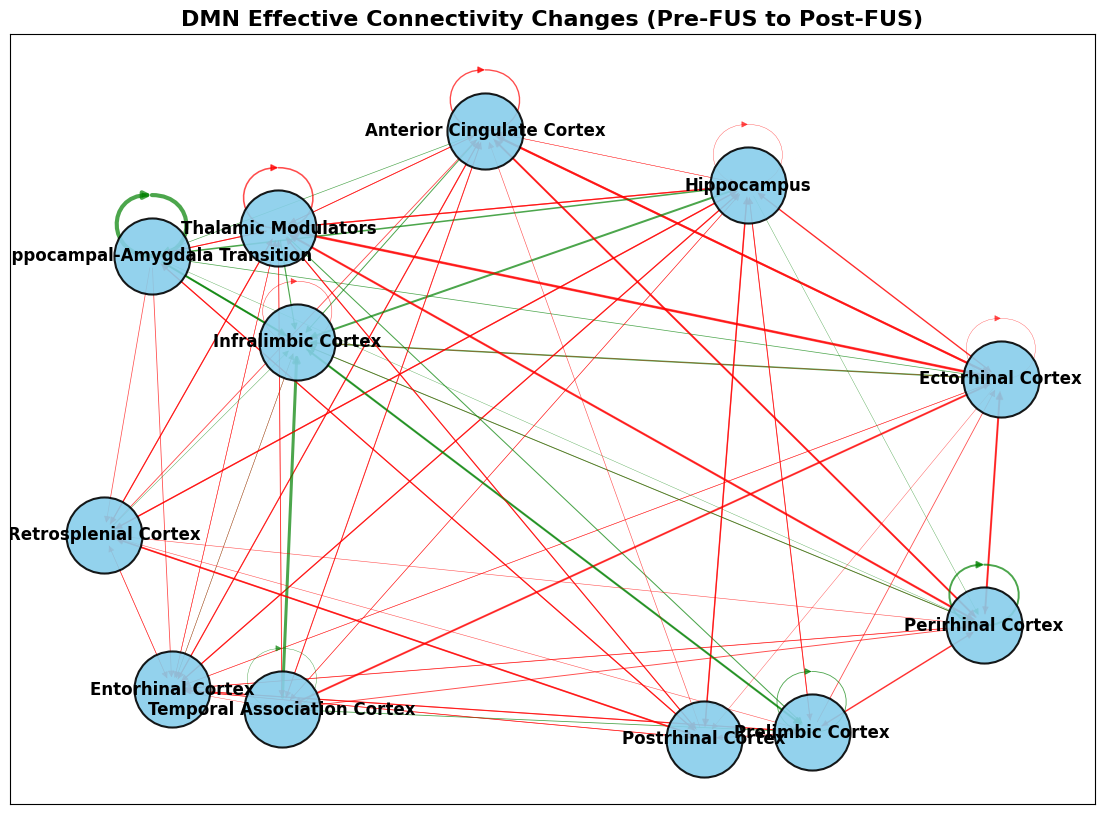

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

gc_df = pd.read_csv("dmn_effective_connectivity_granger.csv")

gc_df.rename(columns={"Unnamed: 0": "Source", "Unnamed: 1": "Target"}, inplace=True)

region_clusters = {
    "Prelimbic Cortex": {239, 241, 242, 243, 244},
    "Infralimbic Cortex": {246, 248, 249, 250, 251},
    "Anterior Cingulate Cortex": {227, 228, 229, 230, 231, 233, 234, 235, 236, 237},
    "Hippocampus": {457, 462, 467, 474, 475, 476, 535, 544, 523, 527, 531},
    "Retrosplenial Cortex": {299, 300, 301, 302, 303, 326, 327, 329, 330, 331, 333, 335, 336, 337, 338},
    "Entorhinal Cortex": {495, 496, 500, 503, 505, 508, 509, 512, 514, 516},
    "Temporal Association Cortex": {361, 362, 363, 364, 365, 366},
    "Perirhinal Cortex": {368, 369, 370, 371, 372},
    "Ectorhinal Cortex": {374, 375, 376, 377, 378},
    "Postrhinal Cortex": {214, 215, 216, 217, 218, 219},
    "Hippocampal-Amygdala Transition": {553, 554},
    "Thalamic Modulators": {675, 678, 679}
}

# Function to assign each region to its cluster
def get_region_cluster(region_id):
    for cluster_name, regions in region_clusters.items():
        if region_id in regions:
            return cluster_name
    return "Unknown"  # For regions not in the DMN

gc_df["Source Cluster"] = gc_df["Source"].apply(get_region_cluster)
gc_df["Target Cluster"] = gc_df["Target"].apply(get_region_cluster)

gc_df = gc_df[(gc_df["Source Cluster"] != "Unknown") & (gc_df["Target Cluster"] != "Unknown")]

gc_clustered = gc_df.groupby(["Source Cluster", "Target Cluster"])[["Pre-FUS", "Post-FUS"]].mean().reset_index()

gc_clustered.to_csv("dmn_effective_connectivity_clustered.csv", index=False)

print(" CSV file 'dmn_effective_connectivity_clustered.csv' has been created successfully!")

# Load the clustered effective connectivity data
gc_clustered = pd.read_csv("dmn_effective_connectivity_clustered.csv")

# Function to create a directed graph
def plot_causal_network(gc_data, title, edge_threshold=0.05):
    G = nx.DiGraph()

    for _, row in gc_data.iterrows():
        source = row["Source Cluster"]
        target = row["Target Cluster"]
        pre_fus = row["Pre-FUS"]
        post_fus = row["Post-FUS"]

        weight_change = post_fus - pre_fus

        if abs(weight_change) > edge_threshold:
            G.add_edge(source, target, weight=weight_change, color="green" if weight_change > 0 else "red")

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, seed=42, k=0.8)

    edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())
    colors = [G[u][v]["color"] for u, v in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="skyblue", edgecolors="black", linewidths=1.5, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, width=[5 * abs(w) for w in weights], alpha=0.7, arrows=True)

    plt.title(title, fontsize=16, fontweight="bold")
    plt.show()

plot_causal_network(gc_clustered, "DMN Effective Connectivity Changes (Pre-FUS to Post-FUS)")